In [7]:
# preprocess.py
# Preprocessing hospital data for predicting patient readmissions

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Step 1: Generate synthetic dataset (EHR-like)
np.random.seed(42)  # For reproducibility

data = {
    'patient_id': range(1000),
    'age': np.random.randint(18, 90, 1000),
    'has_chronic_condition': np.random.choice([0, 1], 1000, p=[0.7, 0.3]),
    'days_since_last_admission': np.random.randint(1, 365, 1000),
    'blood_pressure': np.random.normal(120, 15, 1000),
    'diagnosis_code': np.random.choice(['A01', 'B02', 'C03'], 1000),
    'readmitted': np.random.choice([0, 1], 1000, p=[0.8, 0.2])  # 80% no, 20% yes
}

df = pd.DataFrame(data)

# Step 2: Remove duplicate patients (based on patient_id)
df = df.drop_duplicates(subset='patient_id')
print(f"After removing duplicates, we have {len(df)} records.")

# Step 3: Introduce missing values in blood pressure
missing_indices = np.random.choice(df.index, 50, replace=False)
df.loc[missing_indices, 'blood_pressure'] = np.nan

# Fill missing blood pressure with column mean (safe baseline imputation)
df.loc[:, 'blood_pressure'] = df['blood_pressure'].fillna(df['blood_pressure'].mean())
print("Missing blood pressure values filled with mean.")

# Step 4: Feature engineering
# Add binary indicator for senior patients (65+)
df['is_senior'] = (df['age'] >= 65).astype(int)
print("Added 'is_senior' feature.")

# Step 5: One-hot encode diagnosis_code
df = pd.get_dummies(df, columns=['diagnosis_code'], prefix='diag')
print("Diagnosis codes encoded using one-hot encoding.")

# Step 6: Normalize numeric features using StandardScaler
scaler = StandardScaler()
numeric_cols = ['age', 'blood_pressure', 'days_since_last_admission']
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
print("Normalized numerical features with StandardScaler.")

# Step 7: Save cleaned data for modeling
df.to_csv('preprocessed_data.csv', index=False)
print("Preprocessed data saved to 'preprocessed_data.csv'.")


After removing duplicates, we have 1000 records.
Missing blood pressure values filled with mean.
Added 'is_senior' feature.
Diagnosis codes encoded using one-hot encoding.
Normalized numerical features with StandardScaler.
Preprocessed data saved to 'preprocessed_data.csv'.


In [8]:
# model.py
# Train a model to predict patient readmissions using logistic regression
# Adjusted for class imbalance and includes performance evaluation

import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import pickle

# Step 1: Load the preprocessed data
df = pd.read_csv('preprocessed_data.csv')

# Step 2: Define features (X) and target (y)
X = df.drop(columns=['patient_id', 'readmitted'])
y = df['readmitted']

# Step 3: Split data into train, validation, and test sets (70/15/15) with stratification
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print(f"Training set: {len(X_train)} samples, Validation: {len(X_val)}, Test: {len(X_test)}")

# Step 4: Define logistic regression model with class balancing
model = LogisticRegression(penalty='l2', class_weight='balanced', random_state=42, max_iter=1000)

# Step 5: Hyperparameter tuning using GridSearchCV on 'C' (inverse of regularization strength)
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Step 6: Best model from grid search
best_model = grid_search.best_estimator_
print(f"Best hyperparameter C: {grid_search.best_params_['C']}")
print(f"Best cross-validated F1-Score: {grid_search.best_score_:.3f}")

# Step 7: Evaluate on validation set
y_val_pred = best_model.predict(X_val)
print("\nValidation Set Evaluation:")
print(confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred, digits=3))

# Step 8: Save the trained model
with open('readmission_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print("Trained model saved as 'readmission_model.pkl'.")


Training set: 700 samples, Validation: 150, Test: 150
Best hyperparameter C: 1
Best cross-validated F1-Score: 0.311

Validation Set Evaluation:
[[67 54]
 [11 18]]
              precision    recall  f1-score   support

           0      0.859     0.554     0.673       121
           1      0.250     0.621     0.356        29

    accuracy                          0.567       150
   macro avg      0.554     0.587     0.515       150
weighted avg      0.741     0.567     0.612       150

Trained model saved as 'readmission_model.pkl'.


Predicted class distribution: [78 72]

F1-Score: 0.356
AUC-ROC: 0.587
Precision: 0.250
Recall: 0.621

Classification Report:
              precision    recall  f1-score   support

           0      0.859     0.554     0.673       121
           1      0.250     0.621     0.356        29

    accuracy                          0.567       150
   macro avg      0.554     0.587     0.515       150
weighted avg      0.741     0.567     0.612       150


Confusion Matrix:
[[67 54]
 [11 18]]


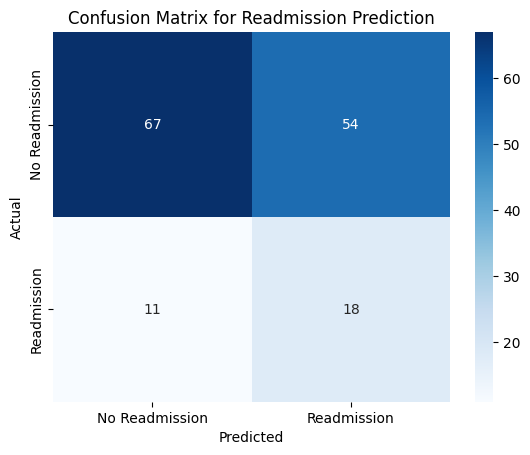

In [9]:
# evaluate.py
# Evaluate the trained readmission model on the test set

import pandas as pd
import pickle
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# Load preprocessed dataset
df = pd.read_csv('preprocessed_data.csv')

# Define features and labels
X = df.drop(columns=['patient_id', 'readmitted'])
y = df['readmitted']

# Match exact split as model.py — get test set (15%)
_, X_temp, _, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
X_test, _, y_test, _ = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Load the trained model
with open('readmission_model.pkl', 'rb') as f:
    model = pickle.load(f)

# Make predictions
y_pred = model.predict(X_test)

# Sanity check — see distribution of predicted classes
print("Predicted class distribution:", np.bincount(y_pred))

# Calculate evaluation metrics
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
auc_roc = roc_auc_score(y_test, y_pred)

print(f"\nF1-Score: {f1:.3f}")
print(f"AUC-ROC: {auc_roc:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")

# Full classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3, zero_division=0))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Visualize the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Readmission', 'Readmission'],
            yticklabels=['No Readmission', 'Readmission'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Readmission Prediction')
plt.savefig('confusion_matrix.png')
plt.show()
